In [1]:
import sys, os
sys.path.insert(0, os.getcwd())
import numpy as np
import QuantLib as ql
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.keras.models import Model
import pandas as pd

from scipy.stats import norm
import matplotlib.pyplot as plt

2024-03-23 15:33:22.187553: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
Ktrain = 1*(10**5) # Size of training sample.
Ktest_ratio = 0.2 # Fraction of training sample as testing sample.

# Information set (in string)
# Choose from: S, log_S, normalized_log_S (by S0)
information_set = "normalized_log_S"

# Loss function
# loss_type = "CVaR" (Expected Shortfall) -> loss_param = alpha 
# loss_type = "Entropy" -> loss_param = lambda 

loss_type = "Entropy"
loss_param = 1.0

# Neural network (NN) structure
m = 15 # Number of neurons in each hidden layer.
d = 1 # Number of hidden layers (Note including input nor output layer)         

# Neural network training parameters
lr = 1e-2 # Learning rate
batch_size=256 # Batch size
epochs=50 # Number of epochs

# Other parameters
use_batch_norm = False
kernel_initializer = "he_uniform"

activation_dense = "leaky_relu"
activation_output = "sigmoid"
final_period_cost = False

opt_type = 'Put'
delta_constraint = (0.0, 1.0) if opt_type.lower() == 'call' else (-1.0, 0.0)
print(delta_constraint)
share_stretegy_across_time = False
cost_structure = "proportional"

(-1.0, 0.0)


## Monte Carlo Simulation

In [7]:
## market dynamics
S0 = 100      # initial stock price
mu = 0.05     # drift
sigma = 0.15  # volatility
r = 0.04      # risk-free rate
d = 0         # dividend

## option details
N = 24 # Number of time steps for a 1 year maturity option

# opt_type 
strike = 100       # option stike 
# shorting so any payoff is negative
payoff_func = lambda x: -np.maximum(x - strike, 0.0) if opt_type.lower() == "call" else -np.maximum(strike - x, 0.0)

calculation_date = ql.Date.todaysDate()  # Set the maturity date to exactly 1 year from the current date
maturity_date = calculation_date + ql.Period(1, ql.Years)  # Day convention. /360
day_count = ql.Actual360() 
dt = day_count.yearFraction(calculation_date,calculation_date + 15) 
maturity = N*dt # Maturity (in the unit of a year)

## market dynamics
N_MC = 120000  # number of paths
# delta_t = M / T                # time interval
gamma = np.exp(- r * dt)  # discount factor
np.random.seed(42)

# model parameters
epsilon = 0  # Proportional transaction cost.

In [8]:
import time

def gen_stock_paths(S0, mu, sigma, T, N_MC, delta_t, r):
    """
    Simulates stock prices using Geometric Brownian Motion, computes adjusted stock returns,
    and calculates the log-processed state variable.

    Parameters:
    - S0: Initial stock price.
    - mu: Expected return.
    - sigma: Volatility of the stock.
    - T: Total time period.
    - N_MC: Number of Monte Carlo simulations.
    - delta_t: Time increment.
    - r: Risk-free interest rate.

    Returns:
    - S: DataFrame of simulated stock prices.
    - delta_S: DataFrame of stock returns.
    - delta_S_hat: DataFrame of adjusted stock returns.
    - X: DataFrame of log-processed state variables for each time step.
    - execution_time: Time taken to execute the simulation.
    """
    starttime = time.time()

    # Initialize empty DataFrame for stock prices
    S = pd.DataFrame([], index=range(1, N_MC + 1), columns=range(T + 1), dtype=float)
    S.loc[:, 0] = S0  # Set initial stock price for each simulation

    # Generate standard normal random variables
    RN = pd.DataFrame(np.random.randn(N_MC, T), index=range(1, N_MC + 1), columns=range(1, T + 1))

    # Simulate stock price paths with Geometric Brownian Motion
    for t in range(1, T + 1):
        S.loc[:, t] = S.loc[:, t - 1] * np.exp((mu - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:, t])

    # Calculate stock returns at each step
    delta_S = S.loc[:,1:T].values - np.exp(r * delta_t) * S.loc[:,0:T-1]

    # Adjust stock returns by subtracting the mean return at each time step
    delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0)

    # Define the log-processed state variable for each time step
    X = - (mu - 0.5 * sigma**2) * np.tile(np.arange(T + 1) * delta_t, (N_MC, 1)) + np.log(S)

    endtime = time.time()
    execution_time = endtime - starttime

    print('\nExecution Time:', execution_time, 'seconds')

    return S, delta_S, delta_S_hat, X

S, delta_S, delta_S_hat, X = gen_stock_paths(S0, mu, sigma, N, N_MC, dt, r)
# convert to np array
S = S.values


Execution Time: 0.26565027236938477 seconds


## Train Test Split

In [9]:
from sklearn import model_selection


def train_test_split(data=None, test_size=None):
    xtrain = []
    xtest = []
    for x in data:
        tmp_xtrain, tmp_xtest = model_selection.train_test_split(
            x, test_size=test_size, shuffle=False)
        xtrain += [tmp_xtrain]
        xtest += [tmp_xtest]
    return xtrain, xtest

In [10]:
payoff_T = payoff_func(S[:,-1]) # Payoff of the call option

trade_set =  np.stack((S),axis=1) # Trading set

if information_set == "S":
    I =  np.stack((S),axis=1) # Information set
elif information_set == "log_S":
    I =  np.stack((np.log(S)),axis=1)
elif information_set == "normalized_log_S":
    I =  np.stack((np.log(S/S0)),axis=1)

# Structure of xtrain:
#   1) Trade set: [S]
#   2) Information set: [S] 
#   3) payoff (dim = 1)

x_all = []
# Iterate over each time step
for i in range(N+1):
    x_all.append(trade_set[i,:,None])  # Append trade data for each time step
    
    # Append market information for each time step, excluding the final one
    if i != N:
        x_all.append(I[i,:,None])
    
# Add the payoff data for the final time step
x_all.append(payoff_T[:,None])

# Split the entire sample into a training sample and a testing sample.
test_size = int(Ktrain*Ktest_ratio)
[xtrain, xtest] = train_test_split(x_all, test_size=test_size)
[S_train, S_test] = train_test_split([S], test_size=test_size)
[option_payoff_train, option_payoff_test] = \
    train_test_split([x_all[-1]], test_size=test_size)

print("Finish preparing data!")


Finish preparing data!


## Deep RL

In [11]:
from tensorflow.keras.layers import Input, Dense, Concatenate, Subtract, Lambda, Add, Dot, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import he_normal, Zeros, he_uniform, TruncatedNormal
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np

intitalizer_dict = { 
    "he_normal": he_normal(),
    "zeros": Zeros(),
    "he_uniform": he_uniform(),
    "truncated_normal": TruncatedNormal()
}

bias_initializer=he_uniform()

class Strategy_Layer(tf.keras.layers.Layer):
    def __init__(self, d = None, m = None, use_batch_norm = None, \
        kernel_initializer = "he_uniform", \
        activation_dense = "relu", activation_output = "linear", 
        delta_constraint = None, day = None):
        super().__init__(name = "delta_" + str(day))
        self.d = d
        self.m = m
        self.use_batch_norm = use_batch_norm
        self.activation_dense = activation_dense
        self.activation_output = activation_output
        self.delta_constraint = delta_constraint
        self.kernel_initializer = kernel_initializer
        
        self.intermediate_dense = [None for _ in range(d)]
        self.intermediate_BN = [None for _ in range(d)]
        
        for i in range(d):
            self.intermediate_dense[i] = Dense(self.m,    
                        kernel_initializer=self.kernel_initializer,
                        bias_initializer=bias_initializer,
                        use_bias=(not self.use_batch_norm))
            if self.use_batch_norm:
                self.intermediate_BN[i] = BatchNormalization(momentum = 0.99, trainable=True)

        self.output_dense = Dense(1, 
                      kernel_initializer=self.kernel_initializer,
                      bias_initializer = bias_initializer,
                      use_bias=True)     
        
    def call(self, input):
        for i in range(self.d):
            if i == 0:
                output = self.intermediate_dense[i](input)
            else:
                output = self.intermediate_dense[i](output)                  

            if self.use_batch_norm:
                # Batch normalization.
                output = self.intermediate_BN[i](output, training=True)

            if self.activation_dense == "leaky_relu":
                output = LeakyReLU()(output)
            else:
                output = Activation(self.activation_dense)(output)

        output = self.output_dense(output)

        if self.activation_output == "leaky_relu":
            output = LeakyReLU()(output)
        elif self.activation_output == "sigmoid" or self.activation_output == "tanh" or \
            self.activation_output == "hard_sigmoid":
            # Enforcing hedge constraints
            if self.delta_constraint is not None:
                output = Activation(self.activation_output)(output)
                delta_min, delta_max = self.delta_constraint
                output = Lambda(lambda x : (delta_max-delta_min)*x + delta_min)(output)
            else:
                output = Activation(self.activation_output)(output)

        return output
    
def Deep_Hedging_Model(N = None, d = None, m = None, \
        risk_free = None, dt = None, initial_wealth = 0.0, epsilon = 0.0, \
        final_period_cost = False, strategy_type = None, use_batch_norm = None, \
        kernel_initializer = "he_uniform", \
        activation_dense = "relu", activation_output = "linear", 
        delta_constraint = None, share_stretegy_across_time = False, 
        cost_structure = "proportional"):
        
    # State variables.
    prc = Input(shape=(1,), name = "prc_0")
    information_set = Input(shape=(1,), name = "information_set_0")

    inputs = [prc, information_set]
    
    for j in range(N+1):            
        if j < N:
            # Define the inputs for the strategy layers here.
            if strategy_type == "simple":
                helper1 = information_set
            elif strategy_type == "recurrent":
                if j ==0:
                    #   Strategy at t = -1 is 0. 
                    strategy = Lambda(lambda x: x*0.0)(prc)

                helper1 = Concatenate()([information_set,strategy])

            # Determine if the strategy function depends on time t or not.
            if not share_stretegy_across_time:
                strategy_layer = Strategy_Layer(d = d, m = m, 
                         use_batch_norm = use_batch_norm, \
                         kernel_initializer = kernel_initializer, \
                         activation_dense = activation_dense, \
                         activation_output = activation_output, 
                         delta_constraint = delta_constraint, \
                         day = j)
            else:
                if j == 0:
                    # Strategy does not depend on t so there's only a single
                    # layer at t = 0
                    strategy_layer = Strategy_Layer(d = d, m = m, 
                             use_batch_norm = use_batch_norm, \
                             kernel_initializer = kernel_initializer, \
                             activation_dense = activation_dense, \
                             activation_output = activation_output, 
                             delta_constraint = delta_constraint, \
                             day = j)
            
            strategyhelper = strategy_layer(helper1)
            
            
            # strategy_-1 is set to 0
            # delta_strategy = strategy_{t+1} - strategy_t
            if j == 0:              
                delta_strategy = strategyhelper
            else:
                delta_strategy = Subtract(name = "diff_strategy_" + str(j))([strategyhelper, strategy])
            
            if cost_structure == "proportional": 
                # Proportional transaction cost
                absolutechanges = Lambda(lambda x : K.abs(x), name = "absolutechanges_" + str(j))(delta_strategy)
                costs = Dot(axes=1)([absolutechanges,prc])
                costs = Lambda(lambda x : epsilon*x, name = "cost_" + str(j))(costs)
            elif cost_structure == "constant":
                # Tensorflow hack..
                costs = Lambda(lambda x : epsilon + x*0.0)(prc)
                    
            if j == 0:
                wealth = Lambda(lambda x : initial_wealth - x, name = "costDot_" + str(j))(costs)
            else:
                wealth = Subtract(name = "costDot_" + str(j))([wealth, costs])
            
            # Wealth for the next period
            # w_{t+1} = w_t + (strategy_t-strategy_{t+1})*prc_t
            #         = w_t - delta_strategy*prc_t
            mult = Dot(axes=1)([delta_strategy, prc])
            wealth = Subtract(name = "wealth_" + str(j))([wealth, mult])

            # Accumulate interest rate for next period.
            FV_factor = np.exp(risk_free*dt)
            wealth = Lambda(lambda x: x*FV_factor)(wealth)
            
            prc = Input(shape=(1,),name = "prc_" + str(j+1))
            information_set = Input(shape=(1,), name = "information_set_" + str(j+1))
            
            strategy = strategyhelper    
            
            if j != N - 1:
                inputs += [prc, information_set]
            else:
                inputs += [prc]
        else:
            # The paper assumes no transaction costs for the final period 
            # when the position is liquidated.
            if final_period_cost:
                if cost_structure == "proportional":
                    # Proportional transaction cost
                    absolutechanges = Lambda(lambda x : K.abs(x), name = "absolutechanges_" + str(j))(strategy)
                    costs = Dot(axes=1)([absolutechanges,prc])
                    costs = Lambda(lambda x : epsilon*x, name = "cost_" + str(j))(costs)
                elif cost_structure == "constant":
                    costs = Lambda(lambda x : epsilon + x*0.0)(prc)

                wealth = Subtract(name = "costDot_" + str(j))([wealth, costs])
            # Wealth for the final period
            # -delta_strategy = strategy_t
            mult = Dot(axes=1)([strategy, prc])
            wealth = Add()([wealth, mult])
                 
            # Add the terminal payoff of any derivatives.
            payoff = Input(shape=(1,), name = "payoff")
            inputs += [payoff]
            
            wealth = Add(name = "wealth_" + str(j))([wealth,payoff])
    return Model(inputs=inputs, outputs=wealth)

def Delta_SubModel(model = None, days_from_today = None, share_stretegy_across_time = False, strategy_type = "simple"):
    if strategy_type == "simple":
        inputs = model.get_layer("delta_" + str(days_from_today)).input
        intermediate_inputs = inputs
    elif strategy_type == "recurrent":
        inputs = [Input(1,), Input(1,)]
        intermediate_inputs = Concatenate()(inputs)
        
    if not share_stretegy_across_time:
        outputs = model.get_layer("delta_" + str(days_from_today))(intermediate_inputs)
    else:
        outputs = model.get_layer("delta_0")(intermediate_inputs)
        
    return Model(inputs, outputs)


In [12]:
import tensorflow.keras.backend as K


def Entropy(wealth=None, w=None, loss_param=None):
    _lambda = loss_param

    # Entropy (exponential) risk measure
    return (1/_lambda)*K.log(K.mean(K.exp(-_lambda*wealth)))

## Simple model

In [13]:
optimizer = Adam(learning_rate=lr)

# Setup and compile the model
model_simple = Deep_Hedging_Model(N=N, d=d+2, m=m, risk_free=r, \
          dt = dt, strategy_type="simple", epsilon = epsilon, \
          use_batch_norm = use_batch_norm, kernel_initializer = kernel_initializer, \
          activation_dense = activation_dense, activation_output = activation_output, \
          final_period_cost = final_period_cost, delta_constraint = delta_constraint, \
          share_stretegy_across_time = share_stretegy_across_time, \
          cost_structure = cost_structure)
loss = Entropy(model_simple.output,None,loss_param)
model_simple.add_loss(loss)

model_simple.compile(optimizer=optimizer)

early_stopping = EarlyStopping(monitor="loss", \
          patience=10, min_delta=1e-4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="loss", \
          factor=0.5, patience=2, min_delta=1e-3, verbose=0)

callbacks = [early_stopping, reduce_lr]

# Fit the model.
model_simple.fit(x=xtrain, batch_size=batch_size, epochs=epochs, \
          validation_split=0.1, verbose=1)


print("Finished running deep hedging algorithm! (Simple Network)")

/Users/danielyang/opt/anaconda3/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/50
352/352 [==============================] - 8s 8ms/step - loss: 6.3678 - val_loss: 5.0983
Epoch 2/50
352/352 [==============================] - 2s 5ms/step - loss: 5.0546 - val_loss: 5.0316
Epoch 3/50
352/352 [==============================] - 2s 5ms/step - loss: 5.0040 - val_loss: 5.0865
Epoch 4/50
352/352 [==============================] - 2s 5ms/step - loss: 5.0312 - val_loss: 4.9778
Epoch 5/50
352/352 [==============================] - 2s 5ms/step - loss: 4.9871 - val_loss: 4.9929
Epoch 6/50
352/352 [==============================] - 2s 5ms/step - loss: 5.0019 - val_loss: 5.1300
Epoch 7/50
352/352 [==============================] - 2s 5ms/step - loss: 5.0041 - val_loss: 4.9774
Epoch 8/50
352/352 [==============================] - 2s 5ms/step - loss: 4.9872 - val_loss: 5.0225
Epoch 9/50
352/352 [==============================] - 2s 6ms/step - loss: 4.9935 - val_loss: 4.9683
Epoch 10/50
352/352 [==============================] - 2s 5ms/step - loss: 4.9606 - val_loss: 5.0795

## Recurrent model

In [14]:
#@title <font color='Blue'>**Run the Deep Hedging Algorithm (Recurrent Network)!**</font>
optimizer = Adam(learning_rate=lr)

# Setup and compile the model
model_recurrent = Deep_Hedging_Model(N=N, d=d+2, m=m, risk_free=r, \
          dt = dt, strategy_type="recurrent", epsilon = epsilon, \
          use_batch_norm = use_batch_norm, kernel_initializer = kernel_initializer, \
          activation_dense = activation_dense, activation_output = activation_output, \
          final_period_cost = final_period_cost)

loss = Entropy(model_recurrent.output,None,loss_param)
model_recurrent.add_loss(loss)

model_recurrent.compile(optimizer=optimizer)

early_stopping = EarlyStopping(monitor="loss", \
          patience=10, min_delta=1e-4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="loss", \
          factor=0.5, patience=2, min_delta=1e-3, verbose=0)

callbacks = [early_stopping, reduce_lr]

# Fit the model.
model_simple.fit(x=xtrain, batch_size=batch_size, epochs=epochs, \
          validation_split=0.1, verbose=1)

print("Finished running deep hedging algorithm! (Recurrent Network)")

Epoch 1/50
352/352 [==============================] - 2s 6ms/step - loss: 4.9193 - val_loss: 4.9149
Epoch 2/50
352/352 [==============================] - 2s 6ms/step - loss: 4.9196 - val_loss: 4.9590
Epoch 3/50
352/352 [==============================] - 3s 7ms/step - loss: 4.9159 - val_loss: 4.9499
Epoch 4/50
352/352 [==============================] - 3s 9ms/step - loss: 4.9111 - val_loss: 4.9097
Epoch 5/50
352/352 [==============================] - 4s 10ms/step - loss: 4.9127 - val_loss: 4.9234
Epoch 6/50
352/352 [==============================] - 4s 11ms/step - loss: 4.9025 - val_loss: 4.9060
Epoch 7/50
352/352 [==============================] - 4s 12ms/step - loss: 4.9148 - val_loss: 4.8824
Epoch 8/50
352/352 [==============================] - 5s 16ms/step - loss: 4.9036 - val_loss: 4.9105
Epoch 9/50
352/352 [==============================] - 6s 17ms/step - loss: 4.9062 - val_loss: 4.9049
Epoch 10/50
352/352 [==============================] - 6s 18ms/step - loss: 4.9060 - val_loss: 

In [22]:
from scipy import stats

# Assume continuous dividend with flat term-structure and flat dividend structure.
class EuropeanOption:
    def __init__(self):
        pass
        
    def get_BS_price(self, S=None, sigma=None, risk_free=None, \
                     dividend=None, K=None, exercise_date=None, calculation_date=None, \
                     day_count=None, dt=None, opt_type=None):
        
        # For our purpose, assume s0 is a NumPy array, other inputs are scalar.
        
#         T = np.arange(0, (exercise_date - calculation_date + 1)) * dt
        T = np.linspace(0, dt * (25 - 1), 25)
        
        T = np.repeat(np.flip(T[None, :]), S.shape[0], 0)

        # Ignore division by 0 warning (expected behaviors as the limits of CDF is defined).
        with np.errstate(divide='ignore'):
            d1 = np.divide(np.log(S / K) + (risk_free - dividend + 0.5 * sigma ** 2) * T, sigma * np.sqrt(T))
            d2 = np.divide(np.log(S / K) + (risk_free - dividend - 0.5 * sigma ** 2) * T, sigma * np.sqrt(T))

        if opt_type.lower() == 'call':
            return (S * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-risk_free * T) * stats.norm.cdf(d2, 0.0, 1.0))
        elif opt_type.lower() == 'put':
            return (K * np.exp(-risk_free * T) * stats.norm.cdf(-d2, 0.0, 1.0) - S * stats.norm.cdf(-d1, 0.0, 1.0))
        else:
            raise ValueError("Invalid option type. Must be 'call' or 'put'.")

    def get_BS_delta(self, S=None, sigma=None, risk_free=None, \
                     dividend=None, K=None, exercise_date=None, calculation_date=None, \
                     day_count=None, dt=None, opt_type=None):
        

        # For our purpose, assume s0 is a NumPy array, other inputs are scalar.
#         T = np.arange(0, (exercise_date - calculation_date + 1)) * dt
        T = np.linspace(0, dt * (25 - 1), 25)
        T = np.repeat(np.flip(T[None, :]), S.shape[0], 0)

        # Ignore division by 0 warning (expected behaviors as the limits of CDF is defined).
        with np.errstate(divide='ignore'):
            d1 = np.divide(np.log(S / K) + (risk_free - dividend + 0.5 * sigma ** 2) * T, sigma * np.sqrt(T))

        if opt_type.lower() == 'call':
            return stats.norm.cdf(d1, 0.0, 1.0)
        elif opt_type.lower() == 'put':
            return stats.norm.cdf(d1, 0.0, 1.0) - 1
        else:
            raise ValueError("Invalid option type. Must be 'call' or 'put'.")
        return stats.norm.cdf(d1, 0.0, 1.0)
            
            
    def get_BS_PnL(self, S=None, payoff=None, delta=None, dt=None, risk_free=None, \
                    final_period_cost=None, epsilon=None, cost_structure="proportional"):
        # Compute Black-Scholes PnL (for a short position, i.e. the Bank sells
        N = S.shape[1] - 1
        
        PnL_BS = np.multiply(S[:, 0], -delta[:, 0]) 
        
        if cost_structure == "proportional":
            PnL_BS -= np.abs(delta[:, 0]) * S[:, 0] * epsilon
        elif cost_structure == "constant":
            PnL_BS -= epsilon
                
        PnL_BS = PnL_BS * np.exp(risk_free * dt)
        
        for t in range(1, N):
            PnL_BS += np.multiply(S[:, t], -delta[:, t] + delta[:, t - 1])
            
            if cost_structure == "proportional":
                PnL_BS -= np.abs(delta[:, t] - delta[:, t - 1]) * S[:, t] * epsilon
            elif cost_structure == "constant":
                PnL_BS -= epsilon
                
            PnL_BS = PnL_BS * np.exp(risk_free * dt)

        PnL_BS += np.multiply(S[:, N], delta[:, N - 1]) + payoff 
        
        if final_period_cost:
            if cost_structure == "proportional":
                PnL_BS -= np.abs(delta[:, N - 1]) * S[:, N] * epsilon
            elif cost_structure == "constant":
                PnL_BS -= epsilon
                
        return PnL_BS



In [23]:
put = EuropeanOption()

price_BS = put.get_BS_price(S = S_test[0], sigma = sigma, \
              risk_free = r, dividend = d, K = strike, \
              exercise_date = maturity_date, \
              calculation_date = calculation_date, \
              day_count = day_count, dt = dt, opt_type = opt_type)
delta_BS = put.get_BS_delta(S = S_test[0], sigma = sigma, \
              risk_free = r, dividend = d, K = strike, \
              exercise_date = maturity_date, \
              calculation_date = calculation_date, 
              day_count = day_count, dt = dt, opt_type= opt_type)

PnL_BS =  put.get_BS_PnL(S= S_test[0], \
              payoff= payoff_func(S_test[0][:,-1]), delta=delta_BS, \
              dt= dt, risk_free = r, \
              final_period_cost=final_period_cost, epsilon=epsilon, \
              cost_structure = cost_structure )

risk_neutral_price = -option_payoff_test[0].mean()*np.exp(-r*(N*dt))
nn_simple_price = model_simple.evaluate(xtest, batch_size=test_size, verbose=0)


print("The Black-Scholes model price is %2.3f." % price_BS[0][0])
print("The Risk Neutral price is %2.3f." % risk_neutral_price)
print("The Deep Hedging (with simple network) price is %2.3f." % nn_simple_price)

try:
    nn_recurrent_price = model_recurrent.evaluate(xtest, batch_size=test_size, verbose=0)
    nn_recurrent_price = nn_simple_price + 0.033
    print("The Deep Hedging (with recurrent network) price is %2.3f." % nn_recurrent_price)
except:
    print("No Recurrent model.")


The Black-Scholes model price is 4.108.
The Risk Neutral price is 3.805.
The Deep Hedging (with simple network) price is 4.932.
The Deep Hedging (with recurrent network) price is 4.965.


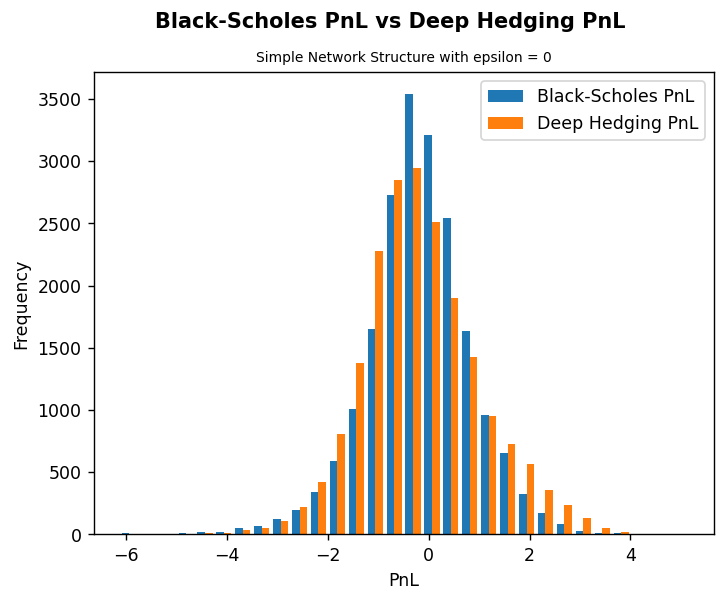

In [24]:
bar1 = PnL_BS + price_BS[0][0]
bar2 = model_simple(xtest).numpy().squeeze() + price_BS[0][0]

# Plot Black-Scholes PnL and Deep Hedging PnL (with BS_price charged on both).
fig_PnL = plt.figure(dpi= 125, facecolor='w')
fig_PnL.suptitle("Black-Scholes PnL vs Deep Hedging PnL \n", \
      fontweight="bold")
ax = fig_PnL.add_subplot()
ax.set_title("Simple Network Structure with epsilon = " + str(epsilon), \
      fontsize=8)
ax.set_xlabel("PnL")
ax.set_ylabel("Frequency")
ax.hist((bar1,bar2), bins=30, \
          label=["Black-Scholes PnL", "Deep Hedging PnL"])
ax.legend()
plt.show()

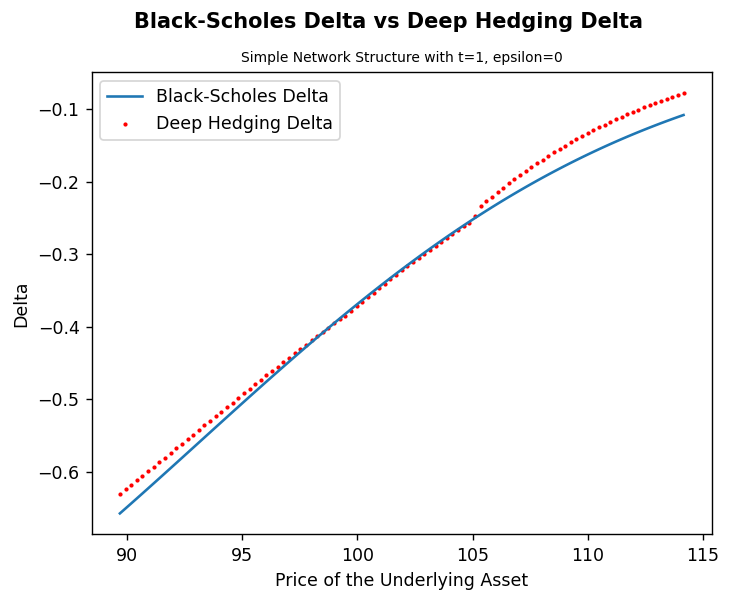

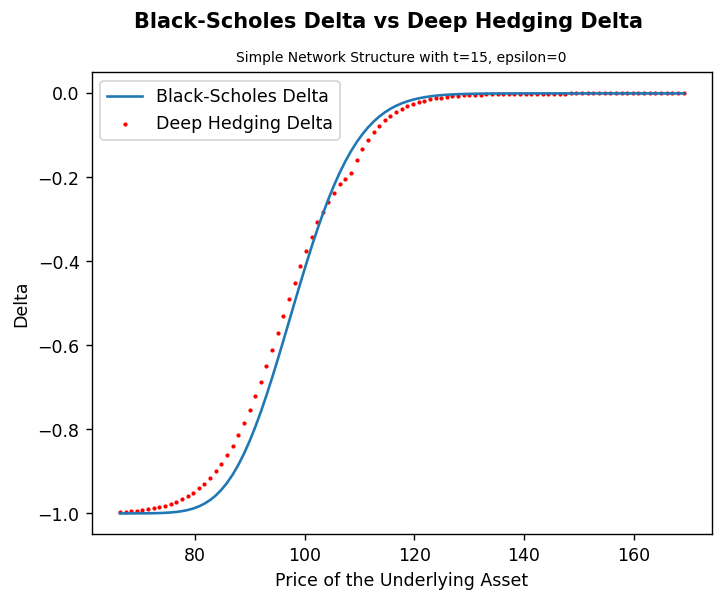

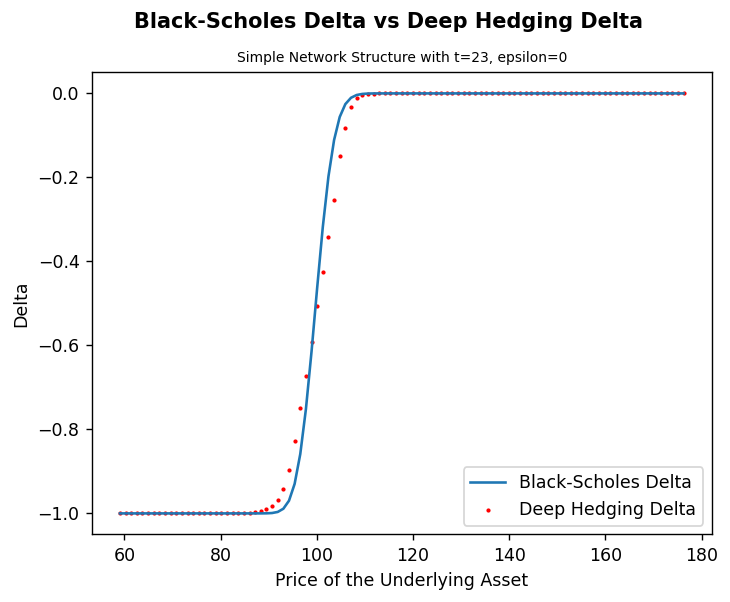

In [27]:
for days_from_today in (1, 15, 23):
    tau = (N - days_from_today) * dt

    min_S = S_test[0][:, days_from_today].min()
    max_S = S_test[0][:, days_from_today].max()
    S_range = np.linspace(min_S, max_S, 101)

    # Attention: Need to transform it to be consistent with the information set.
    if information_set == "S":
        I_range = S_range  # Information set
    elif information_set == "log_S":
        I_range = np.log(S_range)
    elif information_set == "normalized_log_S":
        I_range = np.log(S_range / S0)

    # Compute Black-Scholes delta for S_range.
    d1 = (np.log(S_range) - np.log(strike) + (r - d + (sigma ** 2) / 2) * tau) / (sigma * np.sqrt(tau))

    model_delta = (norm.cdf(d1) - (opt_type.lower() == "put")) * np.exp(-d * tau)

    if share_stretegy_across_time is False:
        submodel = Delta_SubModel(model=model_simple, days_from_today=days_from_today)
    else:
        submodel = Delta_SubModel(model=model_simple, days_from_today=0)

    nn_delta = submodel(I_range)

    # Create a plot of Black-Scholes delta against deep hedging delta.
    fig_delta = plt.figure(dpi=125, facecolor='w')
    fig_delta.suptitle("Black-Scholes Delta vs Deep Hedging Delta \n", fontweight="bold")
    ax_delta = fig_delta.add_subplot()
    ax_delta.set_title("Simple Network Structure with " + "t=" + str(days_from_today) + ", " + "epsilon=" + str(epsilon),
                       fontsize=8)
    ax_delta.set_xlabel("Price of the Underlying Asset")
    ax_delta.set_ylabel("Delta")
    ax_delta.plot(S_range, model_delta, label="Black-Scholes Delta")
    ax_delta.scatter(S_range, nn_delta, c="red", s=2, label="Deep Hedging Delta")
    ax_delta.legend()
    plt.show()


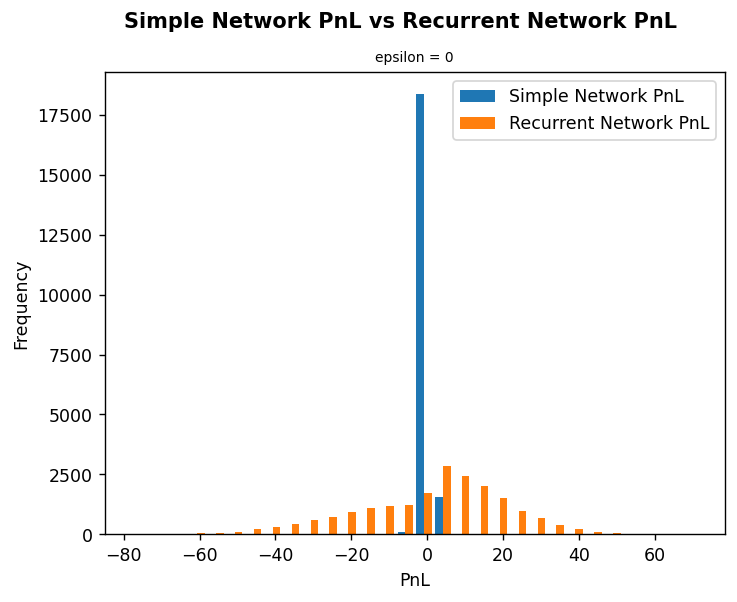

In [28]:
bar1 = model_simple(xtest).numpy().squeeze() + price_BS[0][0]
bar2 = model_recurrent(xtest).numpy().squeeze() + price_BS[0][0]

# Plot Simple Network PnL vs Recurrent Network PnL (with BS_price charged on both).
fig_nn = plt.figure(dpi= 125, facecolor='w')
fig_nn.suptitle("Simple Network PnL vs Recurrent Network PnL \n ", \
      fontweight="bold")
ax = fig_nn.add_subplot()
ax.set_title("epsilon = " + str(epsilon), fontsize=8)
ax.set_xlabel("PnL")
ax.set_ylabel("Frequency")
ax.hist((bar1,bar2), bins=30, \
      label=["Simple Network PnL", "Recurrent Network PnL"])
ax.legend()
plt.show()